# Setup

## Import Modules

In [1]:
import pickle
import os

# data processing
import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy import stats
import encoding_tools
import matplotlib.pyplot as plt
import scipy
import csv

# training and testing
from sklearn import svm, metrics, model_selection
from gpmodel import gpmodel, gpkernel, chimera_tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import TSNE

# Custom imports
import GP_tools as GP

## Import & Process Data

In [2]:
activations = pd.read_csv('./data/activations.csv', index_col=0)
rv_lookup = None
rv_lookup_tsne = None


with open('./data/EFI_ID_List.p', 'rb') as EFI:
    EFIs = pd.Series(map(str, pickle.load(EFI)))
    
with open('./data/metabolite_dict.p', 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)
renaming_dict = dict(zip(range(len(metabolite_dict)), metabolite_dict.values()))

with open('./data/Protein_seq_dict.p', 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)
    

def load_seq(msa=False):
    """
    Load the sequence data. Run before fitting and testing.
    
    Parameters:
        msa (bool): Use MSA aligned sequences (default False)
    """
    global Protein_seq_dict
    Protein_seq_dict = {}
    if msa:
        from Bio import SeqIO
        with open("./data/sequences_muscle.fas") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                Protein_seq_dict[int(record.id)] = str(record.seq.lower())
    else:
        with open('./data/Protein_seq_dict.p', 'rb') as Protein_seq:
            Protein_seq_dict = pickle.load(Protein_seq)
    

def select_X_and_Y(df, x_rows, y_column):
    """
    Select the given X rows and Y column
    """
    # filter out empty columns
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped].loc[x_rows, y_column]
    return x_rows, Ys


def process_data(df, threshold=0, transpose=False, renaming=None):
    """
    Convert numerical absorbance data into categorical data
    (active=1, inactive=-1)
    """
    formatted = df > threshold
    if renaming:
        formatted = formatted.rename(renaming)
    if transpose:
        return formatted.transpose() * 2 - 1
    return formatted * 2 - 1


def prepare_train_test(metabolite_name, threshold=0, reshape=True):
    """
    Format the data and return the training set and testing set.
    """
    df = process_data(activations, threshold=threshold, transpose=True, renaming=renaming_dict)
    xs, ys = select_X_and_Y(df, EFIs, metabolite_name)
    
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFIs:
        Padded_dict[ID] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])

    mapped_xs = xs.map(OH_dict)
    
    if reshape:
        for i, x in enumerate(mapped_xs):
            mapped_xs[i] = x.reshape(len(x)*21)
        
    X = list(mapped_xs)
    y = ys
    
    build_reverse_lookup(X, xs)

    return train_test_split(X, y, test_size=0.2)

def build_reverse_lookup(X, xs, tsne=False):
    """
    Build a lookup dictionary that can retireve the sequence ID associated 
    with the given one-hot-encoded sequence.
    
    Assume sequence is unique. Look up dictionary is saved at `rv_lookup` or
    `rv_lookup_tsne` if tSNE is used.
    """
    global rv_lookup
    global rv_lookup_tsne
    if tsne or ((not tsne) and (rv_lookup is None)):
        reverse_lookup = dict()
        for i in range(len(X)):
            int_arr = X[i].astype('int64')
            flattened = ''.join(map(str, int_arr))
            if tsne:
                flattend = str(X[i])
            if flattened in reverse_lookup:
                raise KeyError('duplicate key {}'.format(flattend))
            else:
                reverse_lookup[flattened] = xs[i]
        if tsne:
            rv_lookup_tsne = reverse_lookup
        else:
            rv_lookup = reverse_lookup
            

def save_result(X_test, y_actual, y_pred, metabolite_name, method, msa=False, directory='./outputs/classifier', lookup={}):
    if msa:
        directory += '/msa'
    filename = '{}/{}_{}.csv'.format(directory, metabolite_name, method)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i in range(len(X_test)):
            x = X_test[i]
            seq_id = lookup[''.join(map(str, np.array(x).astype('int64')))]
            writer.writerow([seq_id, y_actual[i], y_pred[i]])

## Train and Test
Function that trains and tests the data with the provided clf.

In [3]:
def train_test(metabolite_name, threshold=0, clf=None, msa=False):
    """
    Run the optimized classifier for the specific metabolite and report the metrics.
    """
    if clf is None:
        raise ValueError('Classifier is None')
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=threshold)
    
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    save_result(X_test, y_test, result, metabolite_name, type(clf).__name__, lookup=rv_lookup, msa=msa)
    
    print('Metabolite: {}'.format(metabolite_name))
    print('Model statistics:')
    print('\t Recall: {}'.format(recall_score(y_true=y_test, y_pred=result)))
    print('\t Precision: {}'.format(precision_score(y_true=y_test, y_pred=result)))
    print('Confusion matrix:'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()
    

def train_test_tsne(metabolite_name, threshold=0, clf=None, msa=False):
    """
    Run the optimized classifier for the specific metabolite and report the metrics.
    """
    if clf is None:
        raise ValueError('Classifier is None')
    df = process_data(activations, threshold=threshold, transpose=True, renaming=renaming_dict)
    xs, ys = select_X_and_Y(df, EFIs, metabolite_name)

    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFIs:
        Padded_dict[ID] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])
        
    mapped_xs = xs.map(OH_dict)
    for i, x in enumerate(mapped_xs):
        mapped_xs[i] = x.reshape(len(x)*21)
        
    X = list(mapped_xs)
    y = ys
    
    tsne = TSNE(n_components=3, 
                perplexity=20,
                learning_rate=340)
    X_embedded = tsne.fit_transform(X)
    
    build_reverse_lookup(X_embedded, xs, tsne=True)

    X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.2)
    
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    save_result(X_test, y_test, result, metabolite_name, type(clf).__name__+'_tSNE', lookup=rv_lookup_tsne, msa=msa)
    
    print('Metabolite: {}'.format(metabolite_name))
    print('Model statistics:')
    print('\t Recall: {}'.format(recall_score(y_true=y_test, y_pred=result)))
    print('\t Precision: {}'.format(precision_score(y_true=y_test, y_pred=result)))
    print('Confusion matrix:'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

    
def train_test_gp(metabolite_name, threshold=0, msa=False):
    global rv_lookup
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=threshold)
    clf = gpmodel.GPClassifier(gpkernel.MaternKernel('5/2'))
    clf.fit(X_train, y_train)
    f_bar = clf.predict(X_test)[1]
    result = (f_bar > 0) * 2 - 1
    
    save_result(X_test, y_test, result, metabolite_name, type(clf).__name__, lookup=rv_lookup, msa=msa)
    
    print('Metabolite: {}'.format(metabolite_name))
    print('Model statistics:')
    print('\t Recall: {}'.format(recall_score(y_true=y_test, y_pred=result)))
    print('\t Precision: {}'.format(precision_score(y_true=y_test, y_pred=result)))
    print('Confusion matrix:'.format(metabolite_name))
    
    cm = confusion_matrix(y_test, result)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot()
    plt.show()
    

def svm_gridsearch(metabolite_name, X_train, y_train):
    """
    Perform a GridSearchCV to tune the hyperparameters.
    """
    param_grid = {'C': np.linspace(0.1, 1000, 10), 
              'gamma': np.linspace(0.0001, 1, 10),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 
  
    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1)
    grid.fit(X_train, y_train)
    
    return grid

<br>

***

# Classifier using Padded Sequences

## Decision Tree Classifier (Padded-Seq)

Metabolite: Blank
Model statistics:
	 Recall: 0.16666666666666666
	 Precision: 0.6666666666666666
Confusion matrix:


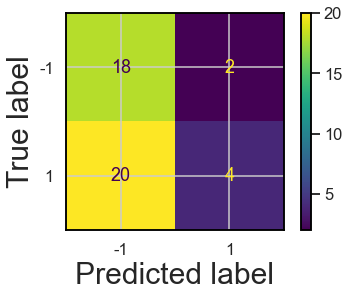


Metabolite: phosphoenolpyruvate
Model statistics:
	 Recall: 0.25925925925925924
	 Precision: 0.875
Confusion matrix:


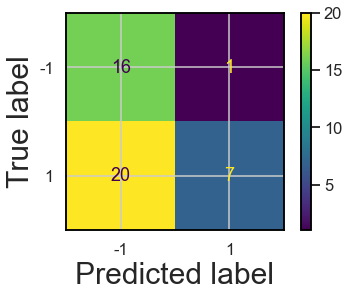


Metabolite: Glycerol-2-phospate
Model statistics:
	 Recall: 0.18518518518518517
	 Precision: 0.625
Confusion matrix:


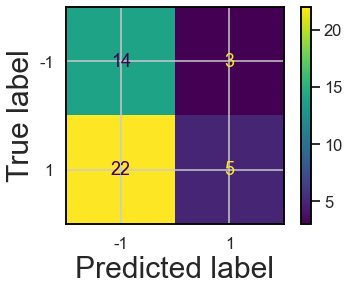


Metabolite: Glycerol-3-phosphate
Model statistics:
	 Recall: 0.2962962962962963
	 Precision: 0.8
Confusion matrix:


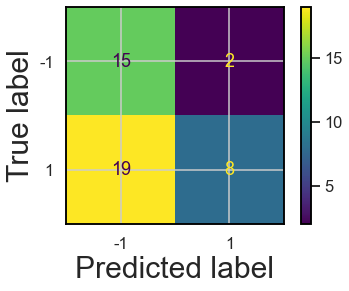


Metabolite: D-erythronate-4-phosphate
Model statistics:
	 Recall: 0.8
	 Precision: 0.5555555555555556
Confusion matrix:


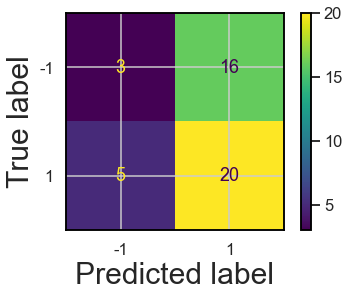

In [4]:
load_seq(msa=False)
decision_tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=6, 
                                           min_samples_leaf=5, min_samples_split=15, 
                                           random_state=42)

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med, clf=decision_tree_clf)
    print()

## Gradient Boosting Classifier (Padded-Seq)

Metabolite: Blank
Model statistics:
	 Recall: 0.5714285714285714
	 Precision: 0.5454545454545454
Confusion matrix:


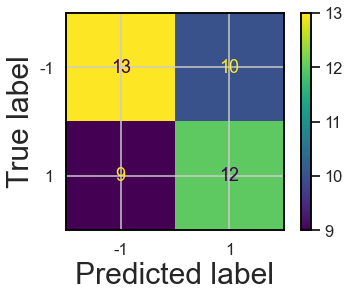


Metabolite: phosphoenolpyruvate
Model statistics:
	 Recall: 0.5
	 Precision: 0.6086956521739131
Confusion matrix:


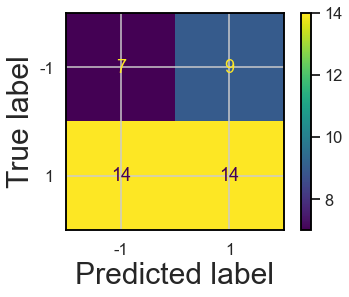


Metabolite: Glycerol-2-phospate
Model statistics:
	 Recall: 0.6111111111111112
	 Precision: 0.5
Confusion matrix:


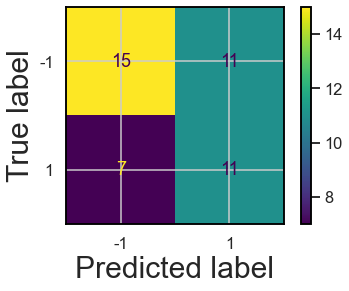


Metabolite: Glycerol-3-phosphate
Model statistics:
	 Recall: 0.5
	 Precision: 0.7368421052631579
Confusion matrix:


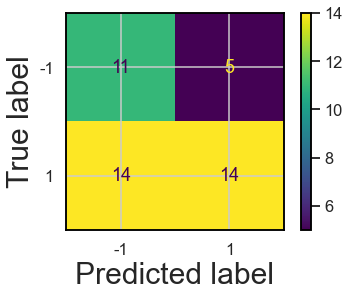


Metabolite: D-erythronate-4-phosphate
Model statistics:
	 Recall: 0.45454545454545453
	 Precision: 0.5
Confusion matrix:


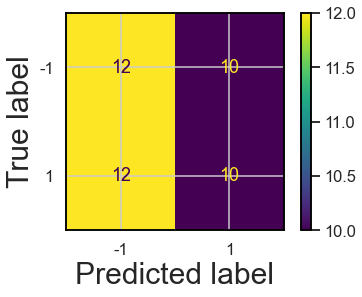

In [5]:
load_seq(msa=False)
grad_boosting_clf = GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                               max_features=0.1, min_samples_leaf=15,
                                               min_samples_split=14, n_estimators=100,
                                               random_state=42, subsample=0.9000000000000001)

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med, clf=grad_boosting_clf)
    print()

## GP Classifier (Padded-Seq)

Metabolite: Blank
Model statistics:
	 Recall: 0.038461538461538464
	 Precision: 1.0
Confusion matrix:


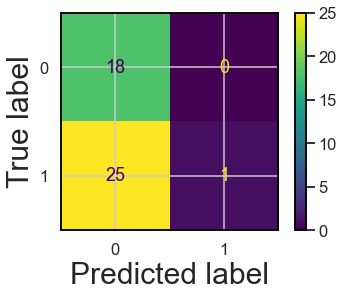


Metabolite: phosphoenolpyruvate
Model statistics:
	 Recall: 0.34615384615384615
	 Precision: 0.5625
Confusion matrix:


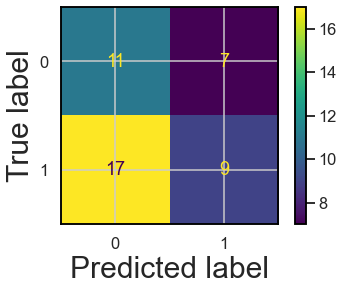


Metabolite: Glycerol-2-phospate
Model statistics:
	 Recall: 0.55
	 Precision: 0.4782608695652174
Confusion matrix:


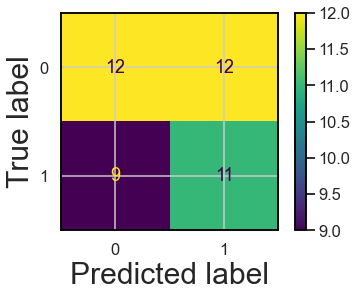


Metabolite: Glycerol-3-phosphate
Model statistics:
	 Recall: 0.2222222222222222
	 Precision: 1.0
Confusion matrix:


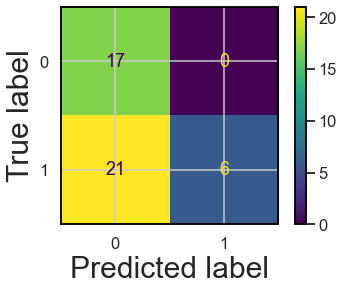


Metabolite: D-erythronate-4-phosphate
Model statistics:
	 Recall: 0.24
	 Precision: 0.8571428571428571
Confusion matrix:


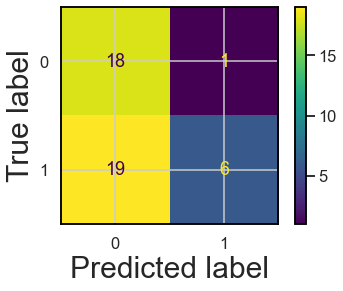

In [6]:
load_seq(msa=False)
# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test_gp(metabolite, threshold=med)
    print()

## SVM Classifier (Padded-Seq)

Metabolite: Blank
Model statistics:
	 Recall: 0.5
	 Precision: 0.4166666666666667
Confusion matrix:


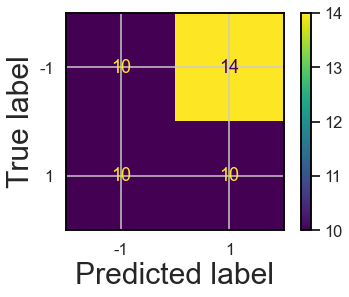


Metabolite: phosphoenolpyruvate
Model statistics:
	 Recall: 0.6666666666666666
	 Precision: 0.5714285714285714
Confusion matrix:


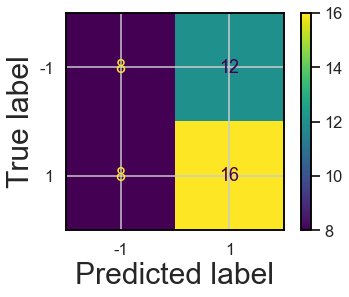


Metabolite: Glycerol-2-phospate
Model statistics:
	 Recall: 0.45
	 Precision: 0.391304347826087
Confusion matrix:


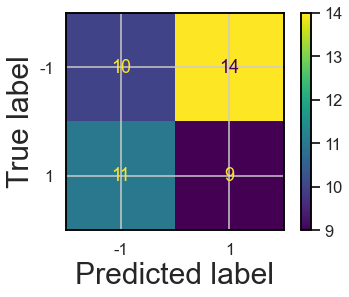


Metabolite: Glycerol-3-phosphate
Model statistics:
	 Recall: 0.5217391304347826
	 Precision: 0.5454545454545454
Confusion matrix:


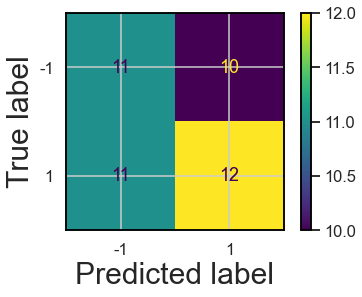


Metabolite: D-erythronate-4-phosphate
Model statistics:
	 Recall: 0.6111111111111112
	 Precision: 0.4782608695652174
Confusion matrix:


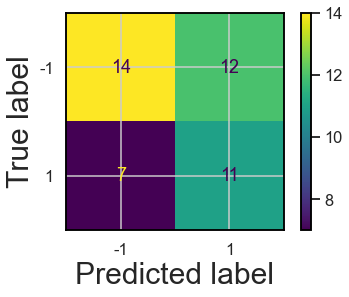

In [7]:
load_seq(msa=False)
svm_clf = svm.SVC(C=222, gamma=0.111, kernel='sigmoid')

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med, clf=svm_clf)
    print()

## SVM Classifier with t-SNE Clustering (Padded-Seq)

Metabolite: Blank
Model statistics:
	 Recall: 0.4583333333333333
	 Precision: 0.55
Confusion matrix:


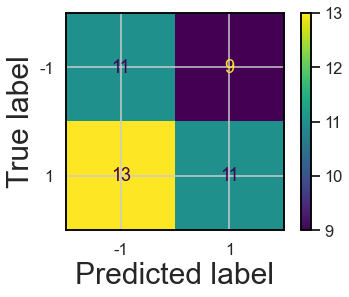


Metabolite: phosphoenolpyruvate
Model statistics:
	 Recall: 0.4090909090909091
	 Precision: 0.5294117647058824
Confusion matrix:


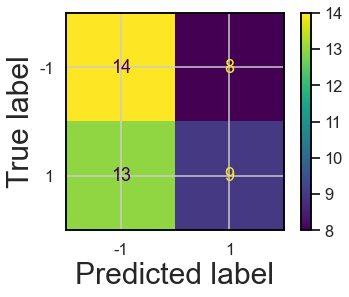


Metabolite: Glycerol-2-phospate
Model statistics:
	 Recall: 0.44
	 Precision: 0.55
Confusion matrix:


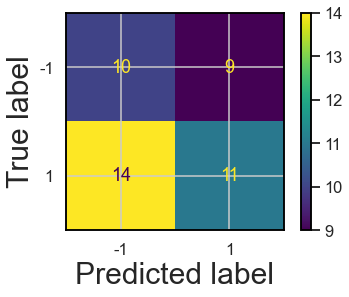


Metabolite: Glycerol-3-phosphate
Model statistics:
	 Recall: 0.625
	 Precision: 0.5555555555555556
Confusion matrix:


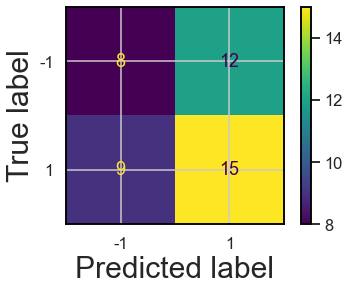

In [ ]:
load_seq(msa=False)
svm_clf = svm.SVC(C=222, gamma=0.111, kernel='sigmoid')

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test_tsne(metabolite, threshold=med, clf=svm_clf)
    print()

<br>

***
# Classification using MSAligned Data

In [ ]:
rv_lookup = None
rv_lookup_tsne = None

## Decision Tree Classifier (MSA)

In [ ]:
load_seq(msa=True)
decision_tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=6, 
                                           min_samples_leaf=5, min_samples_split=15, 
                                           random_state=42)

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med, clf=decision_tree_clf, msa=True)
    print()

## Gradient Boosting Classifier (MSA)

In [ ]:
load_seq(msa=True)
grad_boosting_clf = GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                               max_features=0.1, min_samples_leaf=15,
                                               min_samples_split=14, n_estimators=100,
                                               random_state=42, subsample=0.9000000000000001)

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med, clf=grad_boosting_clf, msa=True)
    print()

## GP Classifier (MSA)

In [ ]:
load_seq(msa=True)
# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test_gp(metabolite, threshold=med, msa=True)
    print()

## SVM Classifier (MSA)

In [ ]:
load_seq(msa=True)
svm_clf = svm.SVC(C=222, gamma=0.111, kernel='sigmoid')

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med, clf=svm_clf, msa=True)
    print()

## SVM Classifier with t-SNE Clustering (MSA)

In [ ]:
load_seq(msa=True)
svm_clf = svm.SVC(C=222, gamma=0.111, kernel='sigmoid')

# remove the slice [:5] to generate data for all
for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test_tsne(metabolite, threshold=med, clf=svm_clf, msa=True)
    print()

# Regression
This part is adopted from the work by https://github.com/anaqiafendi/channels/tree/master/regression

In [ ]:
def ML_train(X, y):
    # test the optimization of the hyp-prams
    initial_guess = [0.9,0.9]

    # take the log of the initial guess for optimiziation 
    initial_guess_log = np.log(initial_guess)

    # optimize to fit model
    result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X,y), method='L-BFGS-B')
    
    print('Full GP regression model')
    print('Hyperparameters: ' + str(np.exp(result.x[0])) + ' ' + str(np.exp(result.x[1])))

    # next set of hyper prams 
    final_prams = [np.exp(result.x[0]), np.exp(result.x[1])]
    
    return final_prams

def ML_predict(X, y, X_true_test, y_true_test, log_data, final_prams, property_, num_iter=1, Substrate_ID=0, metabolite_dict=metabolite_dict):
    substrate = list(metabolite_dict.values())[Substrate_ID]
    
    if not os.path.exists('outputs/loop_figs/' + str(substrate) + '/'):
        os.makedirs('outputs/loop_figs/' + str(substrate) + '/')

    path_outputs = 'outputs/loop_figs/' + str(substrate) + '/'

    # next use trained GP model to predict full test set
    mu_true_test, var_true_test = GP.predict_GP(X, y, X_true_test, final_prams)

    # convert the true test predications and y back to unnormalized data
    y_test_real = np.exp(y_true_test*np.std(log_data)  + np.mean(log_data))
    mu_test_real = np.exp(mu_true_test*np.std(log_data)  + np.mean(log_data))

    if property_ != 'kinetics_off':
        
        par = np.polyfit(y_test_real, mu_test_real, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        
        # coefficient of determination, plot text
        variance = np.var(mu_test_real)
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(y_test_real, mu_test_real)])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set for {}'.format(str(substrate)))
        print('R = %0.3f'% np.sqrt(Rsqr))
        
        # plot and measure correlation
        plt.figure('True test', figsize=(1.5, 1.5))
        plt.plot(y_test_real, mu_test_real, 'o', ms=3, color='k')
        
        max_x = np.max(y_test_real)
        plt.plot([0, max_x], [intercept, slope*max_x+intercept], '-', color='k')
        plt.suptitle('R = %0.3f'% np.sqrt(Rsqr))
        plt.savefig(path_outputs + str(property_)+'_matern_kernel_'+str(num_iter)+'.png', bbox_inches='tight', transparent=False, dpi=300)
        
        plt.show()

    elif property_ == 'kinetics_off':
        
        par = np.polyfit(np.log10(y_test_real), np.log10(mu_test_real), 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        
        # coefficient of determination, plot text
        variance = np.var(np.log10(mu_test_real))
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(np.log10(y_test_real), np.log10(mu_test_real))])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set for {}'.format(str(substrate)))
        print('R = %0.3f'% np.sqrt(Rsqr))
        
        # plot and measure correlation
        plt.figure('True test', figsize=(1.5, 1.5))
        plt.plot(np.log10(y_test_real), np.log10(mu_test_real), 'o',  ms=3, color='k')
        
        max_x = np.max(y_test_real)
        min_x = np.min(y_test_real)
        
        plt.plot([np.log10(min_x), np.log10(max_x)], [np.log10(slope*min_x+intercept), np.log10(slope*max_x+intercept)], '-', color='k')
        
        plt.savefig(path_outputs + str(property_)+'_matern_kernel_'+str(num_iter)+'.png', bbox_inches='tight', transparent=True)
        # plt.show()

    # df_select_test_not_defined
    df_select_test = pd.DataFrame(columns=['y','mu','y_real','mu_real'])

    # export csv with predicted values
    df_select_test['y'] = y_true_test
    df_select_test['mu'] = mu_true_test
    df_select_test['y_real'] = y_test_real
    df_select_test['mu_real'] = mu_test_real

    df_select_test.to_csv(path_outputs+ 'matern_kernel_'+str(num_iter)+'_'+str(property_)+'.csv')
    return

def data_format(X, y):
    # test data only includes gen 10
    # df_test_data = df[df.gen == 10]

    # training data excludes test data (gen 10)
    # df_data = df[df.gen != 10]

    # Clean 0 y data which skews results when having to convert infs
    X = X[y != 0]
    y = y[y != 0]

    # Use random split of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # normalize training data
    log_data = np.log(y_train)

    y_train = (log_data - np.mean(log_data))/np.std(log_data)
    # seq = df_select.seq.values

    # normalize test data
    log_data_test = np.log(y_test)
    y_test = (log_data_test - np.mean(log_data))/np.std(log_data)
    # seq_test = df_select_test.seq.values

    return log_data, X_train, X_test, y_train, y_test 
    
    # seq_test, df_select, df_select_test
    
def prep_inputs(Protein_seq_dict,EFI_ID_List,activations,Substrate_ID=0,trim_long=False):
    
    # Trim length of protein sequences first
    if trim_long == True:
        Trimmed_dict = {}
        New_ID_List = []
        for ID in EFI_ID_List:
            if len(Protein_seq_dict[int(ID)]) <= 300:
                Trimmed_dict[int(ID)] = Protein_seq_dict[int(ID)]
                New_ID_List.append(int(ID))
        Protein_seq_dict = Trimmed_dict
        EFI_ID_List = New_ID_List
    
    # Need to pad protein sequences to the max length of the longest one
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFI_ID_List:
        Padded_dict[int(ID)] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[int(ID)] = encoding_tools.one_hot_seq(seq_input=Padded_dict[int(ID)])

    # Preparing input training data X to feed into ML Model
    input_len = len(OH_dict[EFI_ID_List[0]])*21
    num_inputs = len(OH_dict.keys())

    X = np.zeros((num_inputs,input_len))
    for i in range(0,len(EFI_ID_List)):
        ID = EFI_ID_List[i]
        X_seq = OH_dict[int(ID)]
        X_seq = np.reshape(X_seq,(1,X_seq.shape[0]*21))
        X[i,:] = X_seq

    # Preapre output training data y to feed into ML Model
    dummy = [str(ID) for ID in EFI_ID_List]
    y = activations[dummy].values[Substrate_ID,:]

    return X, y

In [ ]:
def auto_train_test(Protein_seq_dict, EFI_ID_List, activations, Substrate_ID, num_iter, metabolite_dict=metabolite_dict):
    # Need to prep inputs X and Y
    X, y = prep_inputs(Protein_seq_dict,EFI_ID_List,activations,Substrate_ID=Substrate_ID,trim_long=True)

    # Format data for train and test splits
    log_data, X_train, X_test, y_train, y_test = data_format(X, y)

    # Train ML Model on training set
    final_prams = ML_train(X_train, y_train)

    # Predict on test set
    ML_predict(X=X_train, y=y_train, X_true_test=X_test, y_true_test=y_test, log_data=log_data, final_prams=final_prams, property_='activity', num_iter=num_iter, Substrate_ID=Substrate_ID, metabolite_dict=metabolite_dict)

In [ ]:
for j in range(0,5):
    try:
        auto_train_test(Protein_seq_dict, EFIs, activations, Substrate_ID=j, num_iter=20)
    except np.linalg.LinAlgError:
        print('LinAlgError, negative value in eigenvector')